<a href="https://colab.research.google.com/github/kotOcelot/Milky_Way_generator/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты

In [ ]:
from astropy.io import fits
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, random_split
import torch
from PIL import Image
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
from torch import nn
import torch.optim as optim
from scipy.optimize import curve_fit
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from collections import OrderedDict
import random
import torchvision
from torchvision import transforms

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


In [ ]:
from collections import defaultdict
from IPython.display import clear_output


class ProgressPlotter:

    """
    Groups contain a list of variables to output, like ["loss", "accuracy"]
    If group is None all variables will be plotted

    Title is experiment_id like "Relu_Adam_lr003"
    All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="best")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [ ]:
def plot(output, target, maps, labels = ['Output', 'Target', 'Input']):
  for k in range(len(output)):
    if (len(output) != 1):
      pic_rec = output[k]
      pic = target[k]
      map = maps[k]
    else:
      pic_rec = output
      pic = target
      map = maps
    rband_rec = torch.squeeze(pic_rec, 0)
    rband_orig = torch.squeeze(pic, 0)
    map_orig = torch.squeeze(map, 0)
    fig, ax = plt.subplot_mosaic([
        labels
    ], figsize=(14, 5))
    ax[labels[0]].imshow(rband_rec.cpu().detach().numpy())
    ax[labels[1]].imshow(rband_orig.cpu().detach().numpy())
    ax[labels[2]].imshow(torch.squeeze(map_orig).cpu().detach().numpy())
    ax[labels[0]].set_title(labels[0])
    ax[labels[1]].set_title(labels[1])
    ax[labels[2]].set_title(labels[2])
    plt.show()


In [ ]:
def plot_dataset(pics, maps, labels, num = 10):
  for k in range(num):
      pic = pics[k]
      label = labels[k][:6]
      rband_orig = torch.squeeze(pic, 0)
      map_orig = torch.squeeze(map, 0)
      fig, ax = plt.subplot_mosaic([
          ['ha', 'stellar']
      ], figsize=(14, 5))
      ax['ha'].imshow(rband_orig.cpu().detach().numpy())
      ax['stellar'].imshow(torch.squeeze(map_orig).cpu().detach().numpy())
      ax['ha'].set_title(label)
      ax['stellar'].set_title(label)
      plt.show()


# Загрузка данных

In [ ]:
list_files = []
#with open('/content/drive/MyDrive/SDSS Manga data/list.dat') as f:
with open('list.dat') as f:
  for line in f:
      list_files.append(line.replace('%', '')[:-1])
print(len(list_files))
list_files = np.array(list_files)

10214


In [ ]:
rgb_x = []
rgb_y = []
list_corr = []
with open('rgb_orig/rgb_list_2.dat') as f:
     for line in f:
       if line[0] == '%':
         name = line[:14].replace('%', '')
         if (int(line[18:22])>=120) and (int(line[15:18])>=120) and (np.sum(np.isin(list_files, name)) == 1):
           list_corr.append(name)
           rgb_y.append(int(line[15:18]))
           rgb_x.append(int(line[18:22]))
print(np.mean(rgb_y), np.mean(rgb_x))
print(len(list_corr))

241.74204946996466 241.74204946996466
10188


In [ ]:
#list_files_test = list_corr[:1000]
list_files_test = list_corr

In [ ]:
rgbs = []
for name_f in list_files_test:
  name = '{}_rgb.npy'.format(name_f)
  rgb = torch.permute(torch.tensor(np.load('rgb_orig/{}'.format(name))).type(torch.FloatTensor), (2,0,1))
  rgbs.append(rgb)


# Датасет

In [ ]:
class DS_pics(Dataset):
    def __init__(self, images, labels, transform = None):
        super().__init__()
        self.images = images
        self.labels = labels
        #self.v_fields = v_fields
        self.transform = transform

    def __getitem__(self, indx):
        image = self.images[indx]
        label = self.labels[indx]
        #vel_field = self.v_fields[indx]

        if self.transform:
            image = self.transform(image)
            #vel_field = self.transform(vel_field)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
rgb_test = rgbs[:10]
rgb_res = rgbs[10:]
list_test = list_files_test[:10]
list_res = list_files_test[10:]

In [ ]:
transform = transforms.Compose([ transforms.Resize(size = (241, 241))],)

galaxies = DS_pics(rgb_res, list_res, transform=transform)
gal_test = DS_pics(rgb_test, list_test, transform=transform)

In [ ]:
gal_train, gal_val  = random_split(galaxies, [0.9, 0.1])

In [ ]:
train_loader = torch.utils.data.DataLoader(gal_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(gal_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(gal_test, batch_size=len(gal_test), shuffle=False)

# AE

In [ ]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            #nn.AdaptiveAvgPool2d((225, 225)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_autoencoder/best_model.pth')
            return model

In [ ]:
def train(model, criterion, optimizer, num_ep, scheduler=None):
    save_best_model = SaveBestModel()

    progress = {}
    pp = ProgressPlotter(title="baseline", groups=["loss_train", "loss_val"])
    min_loss_val = 10000
    min_loss_train = 10000
    model.train()
    for epoch in range(num_ep):
          ep_loss_train = 0
          for (pic, label) in train_loader:
              optimizer.zero_grad()
              output, encoded = model(pic.to(device))
              for k in range (len(pic)):
                name_f = label[k]
                name = '{}_vector'.format(name_f)
                np.save('vectors/{}'.format(name), torch.squeeze(encoded[k], 0).detach().cpu())
              loss = criterion(output, pic.to(device))
              loss.backward()
              optimizer.step()
              train_loss = loss.item()
              ep_loss_train += train_loss

          ep_loss_val = 0
          model.eval()
          for (pic, label) in val_loader:
              with torch.no_grad():
                  output, encoded = model(pic.to(device))
                  # for k in range (len(pic)):
                  #   name_f = label[k]
                  #   name = '{}_vector'.format(name_f)
                  #   np.save('vectors/{}'.format(name), torch.squeeze(encoded[k], 0).detach().cpu())
                  loss = criterion(output, pic.to(device))
                  val_loss = loss.item()
                  ep_loss_val += loss.item()
                  if scheduler:
                      scheduler.step(val_loss)
          pp.add_scalar(group = "loss_train", value = ep_loss_train/(len(train_loader)), tag = "loss_train")
          pp.add_scalar(group = "loss_val", value = ep_loss_val/(len(val_loader)), tag = "loss_val")
          pp.display()

          save_best_model(ep_loss_val/(len(val_loader)), epoch, model, optimizer, criterion)
    #return best_model

          # if val_loss < min_loss_val:
          #     torch.save({
          #     'epoch': epoch,
          #     'model_state_dict': model.state_dict(),
          #     'optimizer_state_dict': optimizer.state_dict(),
          #     'train loss': train_loss,
          #     'val loss': val_loss,
          #     }, 'models/rgb_to_rgb_best_val.pth')
          #     min_loss_val = val_loss
          # if train_loss < min_loss_train:
          #       torch.save({
          #       'epoch': epoch,
          #       'model_state_dict': model.state_dict(),
          #       'optimizer_state_dict': optimizer.state_dict(),
          #       'train loss': train_loss,
          #       }, 'models/rgb_to_rgb_best_train.pth')
          #       min_loss_train = train_loss
          # torch.save({
          #   'epoch': epoch,
          #   'model_state_dict': model.state_dict(),
          #   'optimizer_state_dict': optimizer.state_dict(),
          #   'train loss': train_loss,
          #   'val loss': val_loss,
          #   }, '/content/drive/MyDrive/SDSS Manga data/models/rgb_to_rgb_epoch_{:3d}.pth'.format(epoch))

## Метрики

In [ ]:
from torchmetrics import StructuralSimilarityIndexMeasure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssim = StructuralSimilarityIndexMeasure().to(device)

In [ ]:
def calculate_ssim(img_batch1, img_batch2):
    vals = []
    for i in range(len(img_batch1)):
        img1 = img_batch1[i][None, :]
        img2 = img_batch2[i][None, :]
        vals.append(ssim(img1, img2).to('cpu').detach().numpy())

    vals = np.array(vals)
    mean = np.mean(vals)
    std = np.std(vals)
    return mean, std

In [ ]:
import torch.nn.functional as F

def ssim_handler_simple_net(data, recon, *args, **kwargs):
    data = data.view(-1, 3, 241, 241)
    recon = recon.view(-1, 3, 241, 241)
    return (-ssim(recon, data) + F.l1_loss(recon, data))

In [ ]:
set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder3().to(device)
criterion = ssim_handler_simple_net#nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.1)

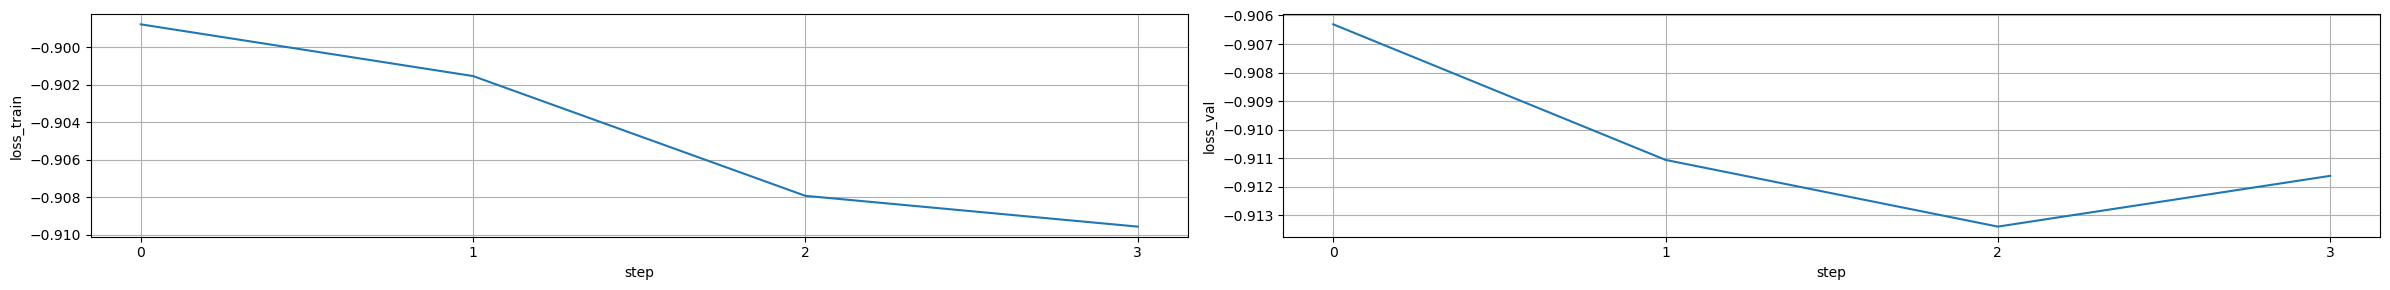

In [ ]:
pr = train(model, criterion, optimizer, 4, scheduler)

In [ ]:
model.eval()
for pic, label in test_loader:
  pic_rec, encoded = model(pic.to(device))
  for k in range (len(pic)):
    name_f = label[k]
    name = '{}_vector'.format(name_f)
    np.save('vectors/{}'.format(name), torch.squeeze(encoded, 0).detach().cpu())

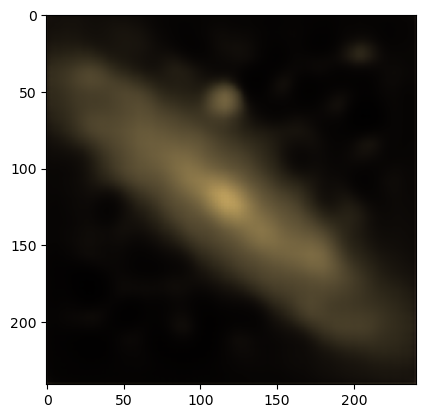

In [ ]:
plt.imshow(torch.permute(pic_rec[2].detach().cpu(), (1,2,0)))

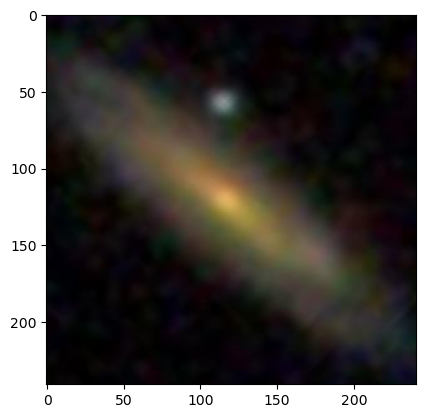

In [ ]:
plt.imshow(torch.permute(pic[2].detach().cpu(), (1,2,0)))

#### MSSSIML2

In [ ]:
class MSSSIML2():
    "A loss layer that calculates alpha*(1-MSSSIM)+(1-alpha)*L2 loss. Assuming bottom[0] is output data and bottom[1] is label, meaning no back-propagation to bottom[1]."

    def setup(self, bottom, top):
        params = eval(self.param_str)
        self.C1 = params.get('C1', 0.01) ** 2
        self.C2 = params.get('C2', 0.03) ** 2
        self.sigma = params.get('sigma', (0.5, 1., 2., 4., 8.))
        self.alpha = params.get('alpha', 0.1)

        # check input pair
        if len(bottom) != 2:
            raise Exception("Need two inputs to compute distance.")

        if (bottom[0].width%2) != 1 or (bottom[1].width%2) != 1 :
            raise Exception("Odd patch size preferred")

    def reshape(self, bottom, top):
        # check input dimensions match
        if bottom[0].count != bottom[1].count:
            raise Exception("Inputs must have the same dimension.")
        # loss output is scalar
        top[0].reshape(1)

        # initialize the size to 5D
        num_scale = len(self.sigma)
        self.width = bottom[0].width
        self.channels = bottom[0].channels
        self.batch = bottom[0].num

        self.w = np.empty((num_scale, self.batch, self.channels, self.width, self.width))
        self.mux = np.empty((num_scale, self.batch, self.channels, 1, 1))
        self.muy = np.empty((num_scale, self.batch, self.channels, 1, 1))
        self.sigmax2 = np.empty((num_scale, self.batch, self.channels, 1, 1))
        self.sigmay2 = np.empty((num_scale, self.batch, self.channels, 1, 1))
        self.sigmaxy = np.empty((num_scale, self.batch, self.channels, 1, 1))
        self.l = np.empty((num_scale, self.batch, self.channels, 1, 1))
        self.cs = np.empty((num_scale, self.batch, self.channels, 1, 1))

		# initialize the gaussian filters based on the bottom size
        for i in range(num_scale):
            gaussian = np.exp(-1.*np.arange(-(self.width/2), self.width/2+1)**2/(2*self.sigma[i]**2))
            gaussian = np.outer(gaussian, gaussian.reshape((self.width, 1)))	# extend to 2D
            gaussian = gaussian/np.sum(gaussian)								# normailization
            gaussian = np.reshape(gaussian, (1, 1, self.width, self.width)) 	# reshape to 4D
            gaussian = np.tile(gaussian, (self.batch, self.channels, 1, 1))
            self.w[i,:,:,:,:] = gaussian

    def forward(self, bottom, top):
        # tile the bottom blob to 5D
        self.bottom0data = np.tile(bottom[0].data, (len(self.sigma), 1, 1, 1, 1))
        self.bottom1data = np.tile(bottom[1].data, (len(self.sigma), 1, 1, 1, 1))

        self.mux = np.sum(self.w * self.bottom0data, axis=(3, 4), keepdims=True)
        self.muy = np.sum(self.w * self.bottom1data, axis=(3, 4), keepdims=True)
        self.sigmax2 = np.sum(self.w * self.bottom0data ** 2, axis=(3, 4), keepdims=True) - self.mux **2
        self.sigmay2 = np.sum(self.w * self.bottom1data ** 2, axis=(3, 4), keepdims=True) - self.muy **2
        self.sigmaxy = np.sum(self.w * self.bottom0data * self.bottom1data, axis=(3, 4), keepdims=True) - self.mux * self.muy
        self.l = (2 * self.mux * self.muy + self.C1)/(self.mux ** 2 + self.muy **2 + self.C1)
        self.cs = (2 * self.sigmaxy + self.C2)/(self.sigmax2 + self.sigmay2 + self.C2)
        self.Pcs = np.prod(self.cs, axis=0)

        loss_MSSSIM = 1 - np.sum(self.l[-1, :, :, :, :] * self.Pcs)/(self.batch * self.channels)
        self.diff = bottom[0].data - bottom[1].data
        loss_L2 = np.sum((self.diff**2) * self.w[-1, :, :, :, :]) / (self.batch * self.channels) / 2.  # L2 loss weighted by Gaussian

        top[0].data[...] = self.alpha * loss_MSSSIM + (1-self.alpha) * loss_L2

    def backward(self, top, propagate_down, bottom):
        self.dl = 2 * self.w * (self.muy - self.mux * self.l) / (self.mux**2 + self.muy**2 + self.C1)
        self.dcs = 2 / (self.sigmax2 + self.sigmay2 + self.C2) * self.w * ((self.bottom1data - self.muy) - self.cs * (self.bottom0data - self.mux))

        dMSSSIM = self.dl[-1, :, :, :, :]
        for i in range(len(self.sigma)):
            dMSSSIM += self.dcs[i, :, :, :, :] / self.cs[i, :, :, :, :] * self.l[-1, :, :, :, :]
        dMSSSIM *= self.Pcs

        diff_L2 = self.diff * self.w[-1, :, :, :, :] / (self.batch * self.channels)		# L2 gradient weighted by Gaussian
        diff_MSSSIM = -dMSSSIM/(self.batch * self.channels)

        bottom[0].diff[...] = self.alpha * diff_MSSSIM + (1-self.alpha) * diff_L2
        bottom[1].diff[...] = 0

In [ ]:
class TorchMSSSIML2(torch.autograd.Function):
    def __init__(self, weight=None, size_average=True):
        super(TorchMSSSIML2, self).__init__()
        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2
        self.sigma = (0.5, 1., 2., 4., 8.)
        self.alpha =  0.1



    @staticmethod
    def forward(ctx, y, y_pred):
        ctx.save_for_backward(y, y_pred)
        return (y_pred - y).pow(2).sum()

    @staticmethod
    def backward(ctx, grad_output):
        yy, yy_pred = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input = 2.0*(yy_pred - yy)
        return grad_input, None

In [ ]:
#!pip install pytorch-msssim

In [ ]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
# reuse the gaussian kernel with SSIM & MS_SSIM.
ms_ssim_module = MS_SSIM(data_range=255, size_average=True, channel=3)


If you need to calculate MS-SSIM/SSIM on normalized images, please denormalize them to the range of [0, 1] or [0, 255] first.

%# X: (N,3,H,W) a batch of normalized images (-1 ~ 1)

%# Y: (N,3,H,W)

X = (X + 1) / 2  # [-1, 1] => [0, 1]

Y = (Y + 1) / 2

ms_ssim_val = ms_ssim( X, Y, data_range=1, size_average=False ) #(N,)

In [ ]:
import torch.nn.functional as F

def ms_ssim_handler_simple_net(data, recon, *args, **kwargs):
    data = data.view(-1, 3, 241, 241)
    recon = recon.view(-1, 3, 241, 241)
    return 0.8*(-ms_ssim_module(recon, data) + 0.2*F.l1_loss(recon, data))

In [ ]:
set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder3().to(device)
criterion = ms_ssim_handler_simple_net#nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.1)

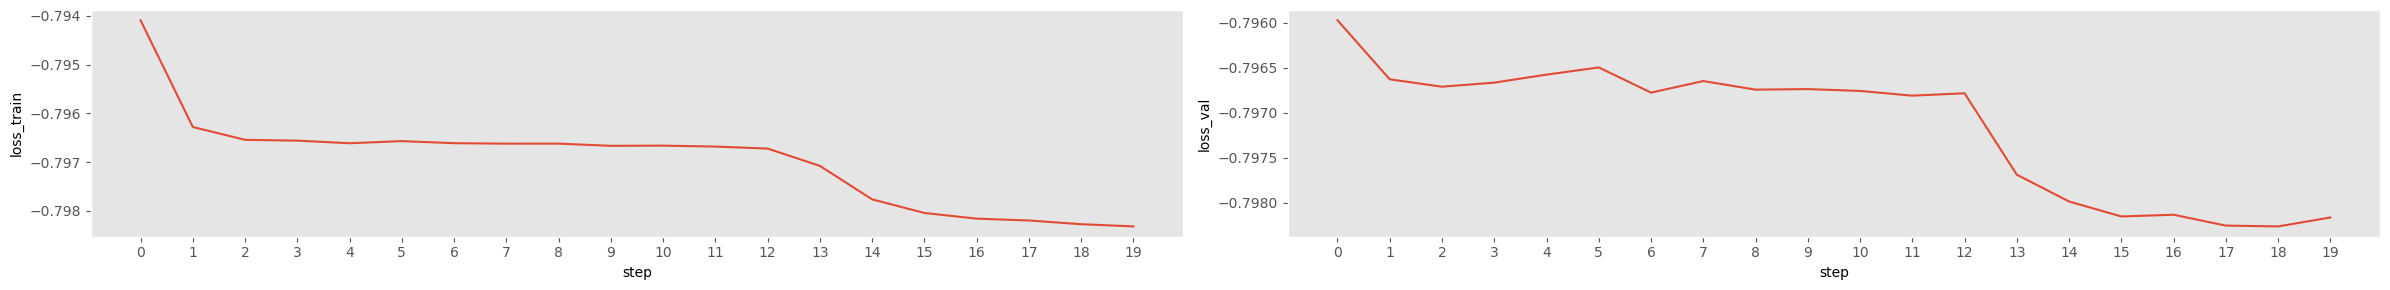

In [ ]:
best_model = train(model, criterion, optimizer, 20, scheduler)

In [ ]:
model.eval()
for pic, label in test_loader:
  pic_rec, encoded = model(pic.to(device))

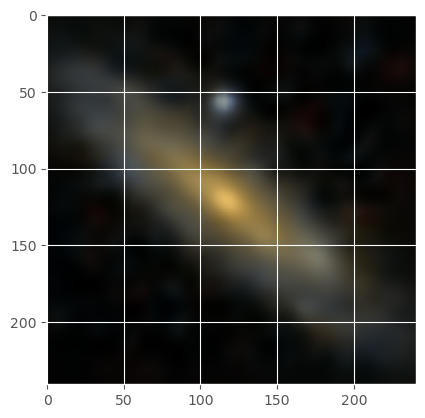

In [ ]:
plt.imshow(torch.permute(pic_rec[2].detach().cpu(), (1,2,0)))

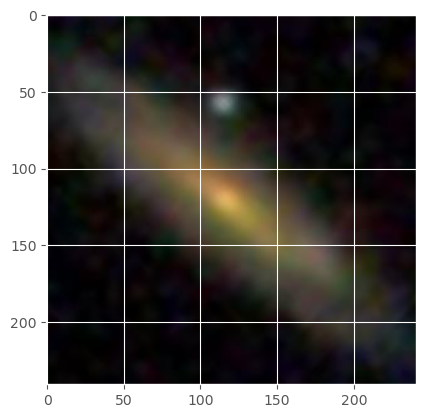

In [ ]:
plt.imshow(torch.permute(pic[2].detach().cpu(), (1,2,0)))

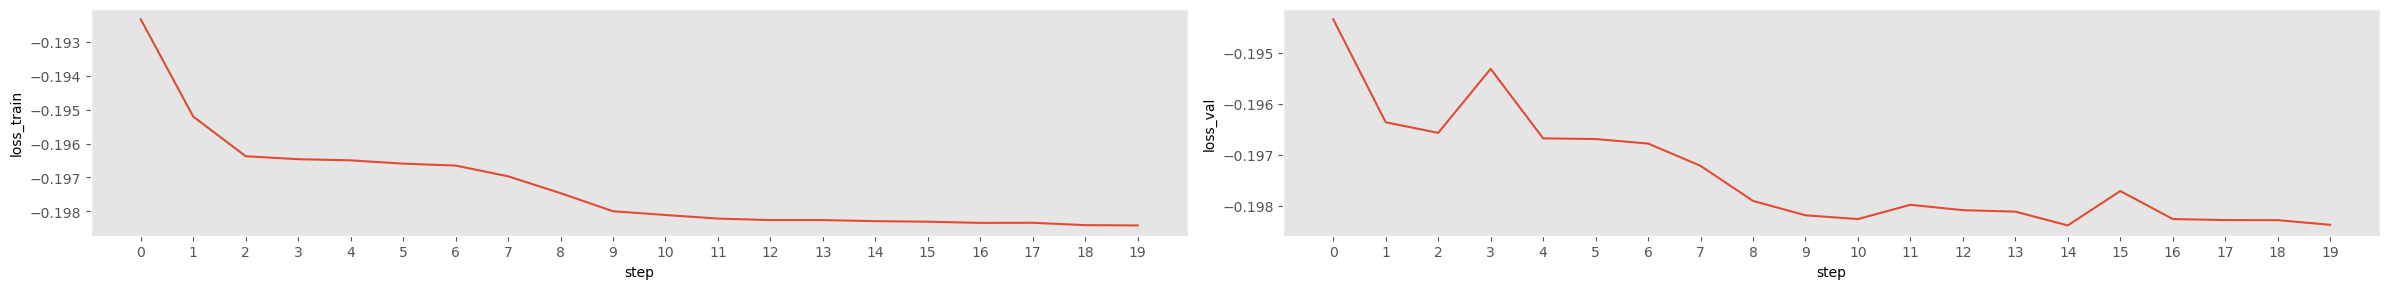

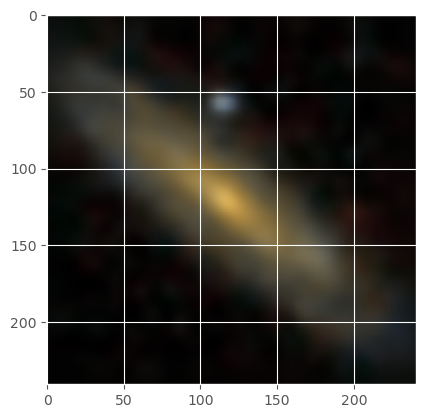

In [ ]:
def ms_ssim_handler_simple_net(data, recon, *args, **kwargs):
    data = data.view(-1, 3, 241, 241)
    recon = recon.view(-1, 3, 241, 241)
    return 0.2*(-ms_ssim_module(recon, data) + 0.8*F.l1_loss(recon, data))

set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder3().to(device)
criterion = ms_ssim_handler_simple_net#nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.1)

best_model = train(model, criterion, optimizer, 20, scheduler)

model.eval()
for pic, label in test_loader:
  pic_rec, encoded = model(pic.to(device))

plt.imshow(torch.permute(pic_rec[2].detach().cpu(), (1,2,0)))

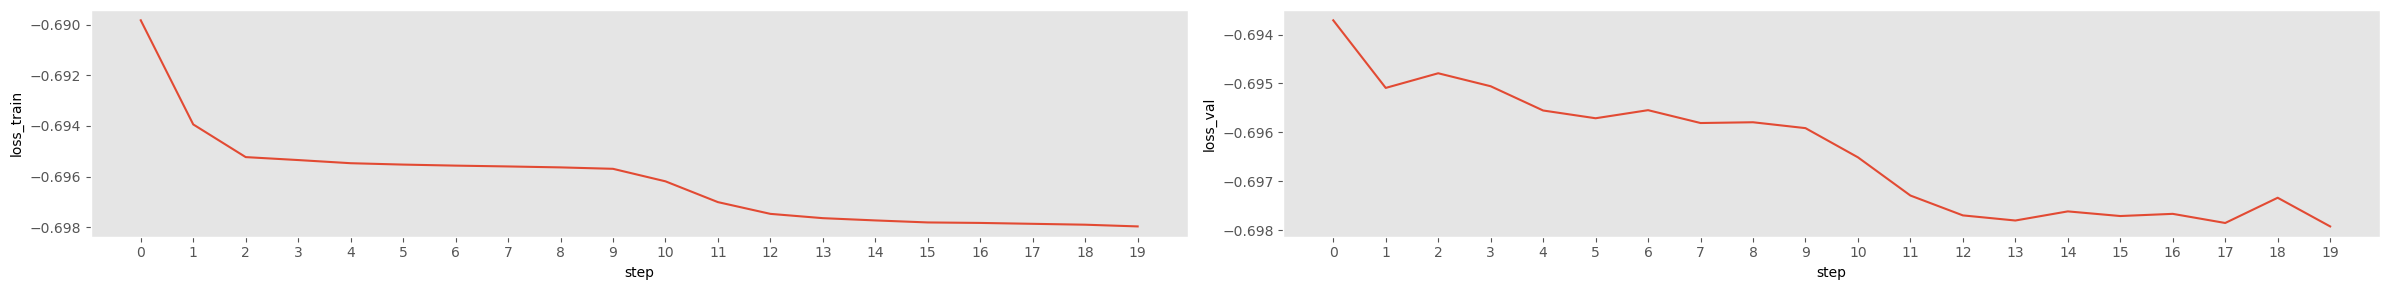


Best validation loss: -0.6979233790189028

Saving best model for epoch: 20



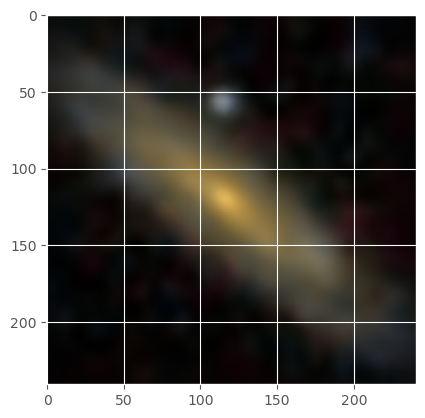

In [ ]:
def ms_ssim_handler_simple_net(data, recon, *args, **kwargs):
    data = data.view(-1, 3, 241, 241)
    recon = recon.view(-1, 3, 241, 241)
    return 0.7*(-ms_ssim_module(recon, data) + 0.3*F.l1_loss(recon, data))

set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder3().to(device)
criterion = ms_ssim_handler_simple_net#nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.1)

pr = train(model, criterion, optimizer, 20, scheduler)

model.eval()
for pic, label in test_loader:
  pic_rec, encoded = model(pic.to(device))

plt.imshow(torch.permute(pic_rec[2].detach().cpu(), (1,2,0)))

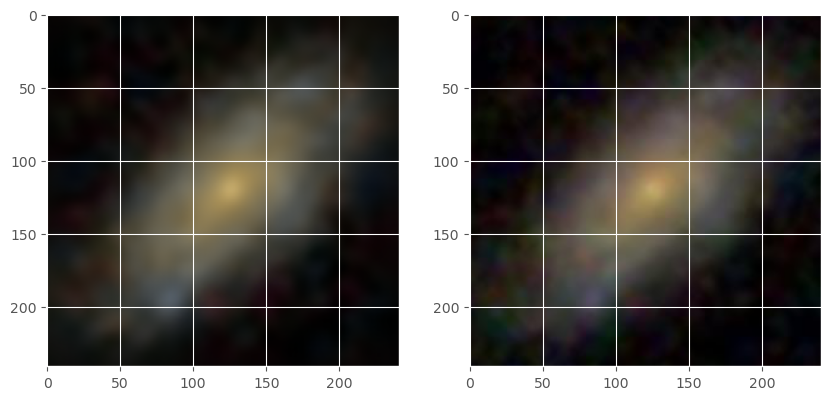

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
# ax1.grid(False)
# ax2.grid(False)
ax1.imshow(torch.permute(pic_rec[4].detach().cpu(), (1,2,0)))
ax2.imshow(torch.permute(pic[4].detach().cpu(), (1,2,0)))

/home/red_alert/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


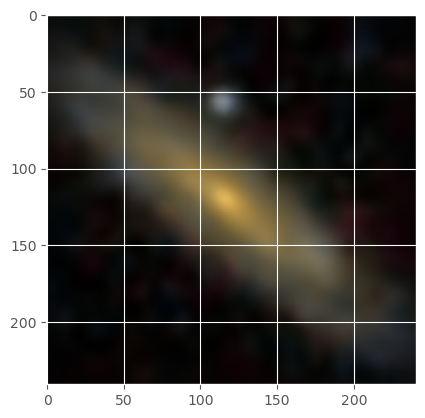

In [ ]:
set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder3().to(device)

checkpoint = torch.load('best_autoencoder/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.to(device)
model.eval()


model.eval()
for pic, label in test_loader:
  pic_rec, encoded = model(pic.to(device))

plt.imshow(torch.permute(pic_rec[2].detach().cpu(), (1,2,0)))

## Сохранение векторов

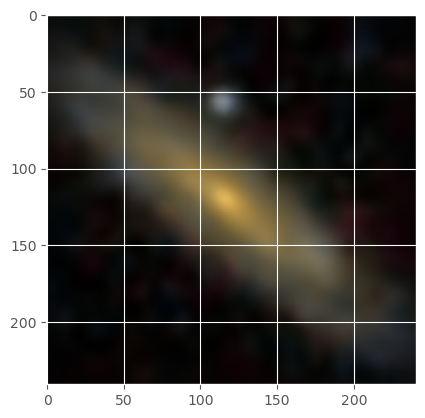

In [ ]:
set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder3().to(device)

checkpoint = torch.load('best_autoencoder/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.to(device)
model.eval()

for pic, label in test_loader:
  pic_rec, encoded = model(pic.to(device))

plt.imshow(torch.permute(pic_rec[2].detach().cpu(), (1,2,0)))


for (pic, label) in train_loader:
    with torch.no_grad():
      output, encoded = model(pic.to(device))
      for k in range (len(pic)):
        name_f = label[k]
        name = '{}_vector'.format(name_f)
        np.save('vectors/{}'.format(name), torch.squeeze(encoded[k], 0).detach().cpu())

for (pic, label) in val_loader:
    with torch.no_grad():
        output, encoded = model(pic.to(device))
        for k in range (len(pic)):
          name_f = label[k]
          name = '{}_vector'.format(name_f)
          np.save('vectors/{}'.format(name), torch.squeeze(encoded[k], 0).detach().cpu())


### Новый энкодер

In [ ]:
class New_encoder(nn.Module):
    def __init__(self):
        super(New_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((12, 12)))

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded


In [ ]:
new_encoder = New_encoder().to(device)
model.encoder = new_encoder.encoder
for param in model.decoder.parameters():
    param.requires_grad = False
for i, param in enumerate(model.parameters()):
      print(i, param.size(), param.requires_grad)

0 torch.Size([64, 1, 3, 3]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64]) True
4 torch.Size([128, 64, 3, 3]) True
5 torch.Size([128]) True
6 torch.Size([128]) True
7 torch.Size([128]) True
8 torch.Size([256, 128, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([256]) True
11 torch.Size([256]) True
12 torch.Size([512, 256, 3, 3]) True
13 torch.Size([512]) True
14 torch.Size([512]) True
15 torch.Size([512]) True
16 torch.Size([512, 256, 3, 3]) False
17 torch.Size([256]) False
18 torch.Size([256]) False
19 torch.Size([256]) False
20 torch.Size([256, 256, 3, 3]) False
21 torch.Size([256]) False
22 torch.Size([256]) False
23 torch.Size([256]) False
24 torch.Size([256, 128, 3, 3]) False
25 torch.Size([128]) False
26 torch.Size([128]) False
27 torch.Size([128]) False
28 torch.Size([128, 128, 3, 3]) False
29 torch.Size([128]) False
30 torch.Size([128]) False
31 torch.Size([128]) False
32 torch.Size([128, 64, 3, 3]) False
33 torch.Size([64]) False
34 torch.Size([64]

In [ ]:
list_files_test = list_corr#[:1000]
list0 = list_files_test

In [ ]:
disp = []
vel = []
vectors = []
list_names = []
for name_f in list0:
  name = '{}_star_disp.pt'.format(name_f)
  std = torch.load('st_disp/{}'.format(name)).type(torch.FloatTensor)
  disp.append(std)
  name = '{}_star_vel.pt'.format(name_f)
  stvel = torch.load('st_vel/{}'.format(name)).type(torch.FloatTensor)
  vel.append(stvel)
  name = '{}_vector.npy'.format(name_f)
  vec = torch.tensor(np.load('vectors/{}'.format(name))).type(torch.FloatTensor)
  vectors.append(vec)

### Считывание параметров фита плоскостью

In [ ]:
names = []
a = []
b = []
c = []
with open('st_vel/star_vel_list.dat') as f:
     for line in f:
      if line[0] == '%':
          names.append(line[:14].replace('%', ''))
          l = 0
          ln = line[15:-1].split(' ')
          for f in range(len(ln)):
            if ln[f]!='':
              l += 1
              if l == 3:
                a.append(ln[f])
              if l == 4:
                b.append(ln[f])
              if l == 5:
                c.append(ln[f])
list_a = []
list_b = []
list_c = []
for name in list0:
  ind = np.where(np.array(names) == name)[0][0]
  list_a.append(float(a[ind]))
  list_b.append(float(b[ind]))
  list_c.append(float(c[ind]))

### Датасет

In [ ]:
class FindPolar(object):

    def __init__(self):
        super().__init__()

    def __call__(self, map):
        ny, nx = map.size()
        x = np.arange(nx)
        y = np.arange(ny)
        xv, yv = np.meshgrid(x, y)
        yv = np.flip(yv, 0)
        if (nx%2 == 1):
          x_c = nx//2 + 1
        else:
          x_c = nx//2
        if (ny%2 == 1):
          y_c = ny//2 + 1
        else:
          y_c = ny//2
        xv = xv + 1 - x_c
        yv = yv + 1 - y_c
        r = np.sqrt(xv**2 + yv**2)
        phi = np.arctan2(yv,xv)
        m2 = map.flatten()
        mask = torch.isnan(m2)
        m2 = m2[~mask]
        r2 = r.flatten()
        r2 = r2[~mask]
        phi2 = phi.flatten()
        phi2 = phi2[~mask]
        vrphi = torch.tensor(np.vstack((m2, r2, phi2)).T).type(torch.FloatTensor)

        return vrphi

In [ ]:
class NormalizeLog(object):

    def __init__(self):
        super().__init__()

    def __call__(self, tensor, min):
        # tensor = torch.log10(tensor + abs(min) + 1)
        # #print (tensor.shape)
        # # mins = tensor.min(dim=1, keepdim=True)
        # # maxs = tensor.max(dim=1, keepdim=True)
        # # tensor = (tensor - mins) / (maxs - mins)
        # X_std = (tensor - tensor.min(axis=0)) / (tensor.max(axis=0) - tensor.min(axis=0))
        # X_scaled = X_std * (max - min) + min
        min = np.nanmin(tensor)
        max = np.nanmax(tensor)
        X_std = (tensor - min) / (max  - min)
        X_scaled = X_std * (max - min) + min

        return X_scaled#tensor

In [ ]:
class FindResVel(object):

    def __init__(self):
        super().__init__()

    def surface(self):
      x = self.xy[:,0]
      y = self.xy[:,1]
      v = (self.a)*x + (self.b)*y + self.c
      return v

    def res_vel(self):
      ny, nx = self.tensor.size()
      x = np.arange(nx)
      y = np.arange(ny)
      xv, yv = np.meshgrid(x, y)
      t2 = self.tensor.flatten()
      xv2 = xv.flatten()
      yv2 = yv.flatten()
      self.xy = np.vstack((xv2, yv2)).T
      surf = torch.FloatTensor(self.surface())
      tensor = self.tensor - surf.view(ny, nx)
      return tensor

    def __call__(self, tensor, coefs):
        self.tensor = tensor
        self.a = coefs[0]
        self.b = coefs[1]
        self.c = coefs[2]
        tensor = self.res_vel()

        return tensor

In [ ]:
class DS_vectors(Dataset):
    def __init__(self, vels, disps, vectors, coefs, norm = NormalizeLog(), polar = FindPolar(), res = FindResVel()):
        super().__init__()
        self.vels = vels
        self.disps = disps
        self.a = coefs[0]
        self.b = coefs[1]
        self.c = coefs[2]
        self.vectors = vectors
        self.polar = polar
        self.norm = norm
        self.res = res


    def __getitem__(self, indx):
        vel = self.vels[indx]
        disp = self.disps[indx]
        a0 = self.a[indx]
        b0 = self.b[indx]
        c0 = self.c[indx]
        vector = self.vectors[indx]
        min_vel = np.nanmin(vel)
        min_disp = np.nanmin(disp)
        disp = self.norm(disp, min_disp)
        disp = self.polar(disp)
        vel = self.res(vel, [a0,b0,c0])
        vel = self.norm(vel, min_vel)
        vel = self.polar(vel)
        map = torch.unsqueeze(torch.concatenate((disp, vel),0), 0)
        return map, vector

    def __len__(self):
        return len(self.vels)

In [ ]:
vec_test = vectors[:10]
vec_res = vectors[10:]
d_test = disp[:10]
d_res = disp[10:]
v_test = vel[:10]
v_res = vel[10:]
list_a_test = list_a[:10]
list_a_res = list_a[10:]
list_b_test = list_b[:10]
list_b_res = list_b[10:]
list_c_test = list_c[:10]
list_c_res = list_c[10:]
list_names_test = list0[:10]

In [ ]:
galaxies_2 = DS_vectors(v_res, d_res, vec_res, [list_a_res, list_b_res, list_c_res])
gal_test_2 = DS_vectors(v_test, d_test, vec_test, [list_a_test, list_b_test, list_c_test])

In [ ]:
gal_train_2, gal_val_2  = random_split(galaxies_2, [0.9, 0.1])
#gal_train_2, gal_val_2  = random_split(galaxies_2, [800, 198])

In [ ]:
train_loader_2 = torch.utils.data.DataLoader(gal_train_2, batch_size=1, shuffle=True)
val_loader_2 = torch.utils.data.DataLoader(gal_val_2, batch_size=1, shuffle=False)
test_loader_2 = torch.utils.data.DataLoader(gal_test_2, batch_size=1, shuffle=False)

### Обучение

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_new_autoencoder/best_new_model.pth')
            return model

In [ ]:
def train_maps(model, criterion, optimizer, num_ep, scheduler=None):
    sbb = SaveBestModel()
    progress = {}
    pp = ProgressPlotter(title="baseline", groups=["loss_train", "loss_val"])
    min_loss_val = 10000
    min_loss_train = 10000
    for epoch in range(num_ep):
          ep_loss_train = 0
          model.train()
          for (map, vec) in train_loader_2:
              optimizer.zero_grad()
              output, encoded = model(map.to(device))
              loss = criterion(encoded, vec.to(device))
              loss.backward()
              optimizer.step()
              train_loss = loss.item()
              ep_loss_train += train_loss

          ep_loss_val = 0
          model.eval()
          for (map, vec) in val_loader_2:
              with torch.no_grad():
                  output, encoded = model(map.to(device))
                  loss = criterion(encoded, vec.to(device))
                  val_loss = loss.item()
                  ep_loss_val += loss.item()
                  if scheduler:
                      scheduler.step(val_loss)
          pp.add_scalar(group = "loss_train", value = ep_loss_train/(len(train_loader)), tag = "loss_train")
          pp.add_scalar(group = "loss_val", value = ep_loss_val/(len(val_loader)), tag = "loss_val")
          pp.display()


          sbb(ep_loss_val/(len(val_loader)), epoch, model, optimizer, criterion)

          if val_loss < min_loss_val:
              torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train loss': train_loss,
              'val loss': val_loss,
              }, 'models/vec_to_rgb_best_val.pth')
              min_loss_val = val_loss
          if train_loss < min_loss_train:
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train loss': train_loss,
                }, 'models/vec_to_rgb_best_train.pth')
                min_loss_train = train_loss
          # torch.save({
          #   'epoch': epoch,
          #   'model_state_dict': model.state_dict(),
          #   'optimizer_state_dict': optimizer.state_dict(),
          #   'train loss': train_loss,
          #   'val loss': val_loss,
          #   }, '/content/drive/MyDrive/SDSS Manga data/models/vec_to_rgb_epoch_{:3d}.pth'.format(epoch))

In [ ]:
set_random_seed(42)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.01)
pr = train_maps(model, criterion, optimizer, 100, scheduler)

/home/red_alert/anaconda3/lib/python3.10/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


RuntimeError: Calculated padded input size per channel: (2 x 5). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

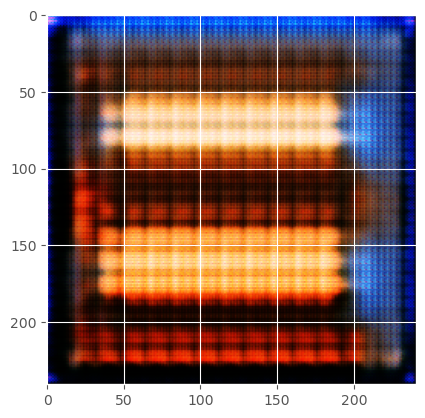

In [ ]:
model.eval()
for map, vector in test_loader_2:
  pic_rec, encoded = model(map.to(device))
plt.imshow(torch.permute(pic_rec[0].detach().cpu(), (1,2,0)))

In [ ]:
mw_disp = torch.unsqueeze(torch.tensor(np.load('dispz_mw.npy')).type(torch.FloatTensor), 0)
mw_vel = torch.unsqueeze(torch.tensor(np.load('vz_mw.npy')).type(torch.FloatTensor), 0)

In [ ]:
class DS_mw(Dataset):
    def __init__(self, vels, disps, norm = NormalizeLog(), polar = FindPolar()):
        super().__init__()
        self.vels = vels
        self.disps = disps
        self.polar = polar
        self.norm = norm

    def __getitem__(self, idx):
        vel = self.vels[idx]
        disp = self.disps[idx]
        min_vel = np.nanmin(vel)
        min_disp = np.nanmin(disp)
        disp = self.norm(disp, min_disp)
        disp = self.polar(disp)
        vel = self.norm(vel, min_vel)
        vel = self.polar(vel)
        map = torch.unsqueeze(torch.concatenate((disp, vel),0), 0)
        return map

    def __len__(self):
        return len(self.vels)

In [ ]:
milky_way = DS_mw(mw_vel, mw_disp)

In [ ]:
mw_loader = torch.utils.data.DataLoader(milky_way, batch_size=1, shuffle=False)

In [ ]:
model.eval()
for map in mw_loader:
  pic_rec, _ = model(map.to(device))

In [ ]:
pic_rec.shape

torch.Size([1, 3, 241, 241])

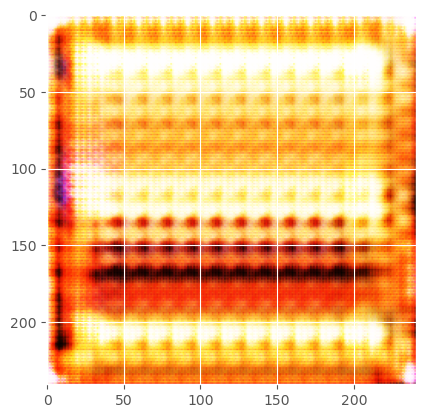

In [ ]:
plt.imshow(torch.permute(pic_rec[0].detach().cpu(), (1,2,0)))

# Pyramid autoencoder


In [ ]:
import torch
import torch.nn as nn


class FeaturePyramidNetwork(nn.Module):
    def __init__(self):
        super(FeaturePyramidNetwork, self).__init__()
        self.name = "AEFPNC"
        self.bn0 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # 3x256x256 -> 16x256x256
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # 16x256x256  -> 32x256x256
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 32x256x256 -> 64x256x256
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=3, padding=1)  # 64x256x256 -> 48x256x256
        self.bn4 = nn.BatchNorm2d(num_features=48)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=32, kernel_size=3, padding=1)  # 48x256x256 -> 32x256x256
        self.bn5 = nn.BatchNorm2d(num_features=32)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=24, kernel_size=3, padding=1)  # 32x256x256 -> 24x256x256
        self.bn6 = nn.BatchNorm2d(num_features=24)
        self.conv7 = nn.Conv2d(in_channels=24, out_channels=16, kernel_size=3, padding=1)  # 24x256x256 -> 16x256x256
        self.bn7 = nn.BatchNorm2d(num_features=16)
        self.down = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2)
        self.conv_smooth1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv_smooth2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_smooth3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.convtrans1 = nn.ConvTranspose2d(in_channels=16, out_channels=24, kernel_size=3, padding=1)
        self.convtrans2 = nn.ConvTranspose2d(in_channels=24, out_channels=32, kernel_size=3, padding=1)
        self.convtrans3 = nn.ConvTranspose2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        self.convtrans4 = nn.ConvTranspose2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.convtrans5 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.convtrans6 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.convtrans7 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        # ============ Encoder ===========
        # ====== Bottom Up Layers =====
        x = self.bn0(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        _, _, H1, W1 = x.size()
        # ======= Branch network ======
        x_d1 = self.down(x)  # 128x128
        _, _, H2, W2 = x_d1.size()
        x_d2 = self.down(x_d1)  # 64x64
        _, _, H3, W3 = x_d2.size()
        x_d3 = self.down(x_d2)  # 32x32
        # ======= First Branch =======
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.bn5(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.bn6(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.bn7(x)
        # ======= Second Branch ========
        x_d1 = self.conv4(x_d1)
        x_d1 = self.relu(x_d1)
        x_d1 = self.bn4(x_d1)
        x_d1 = self.conv5(x_d1)
        x_d1 = self.relu(x_d1)
        x_d1 = self.bn5(x_d1)
        x_d1 = self.conv6(x_d1)
        x_d1 = self.relu(x_d1)
        x_d1 = self.bn6(x_d1)
        x_d1 = self.conv7(x_d1)
        x_d1 = self.relu(x_d1)
        x_d1 = self.bn7(x_d1)
        x_d1 = self.upsample(x_d1, size=(H1, W1))
        # ======= Third Branch ========
        x_d2 = self.conv4(x_d2)
        x_d2 = self.relu(x_d2)
        x_d2 = self.bn4(x_d2)
        x_d2 = self.conv5(x_d2)
        x_d2 = self.relu(x_d2)
        x_d2 = self.bn5(x_d2)
        x_d2 = self.conv6(x_d2)
        x_d2 = self.relu(x_d2)
        x_d2 = self.bn6(x_d2)
        x_d2 = self.conv7(x_d2)
        x_d2 = self.relu(x_d2)
        x_d2 = self.bn7(x_d2)
        x_d2 = self.upsample(x_d2, size=(H2, W2))
        x_d2 = self.upsample(x_d2, size=(H1, W1))
        # ======= Fourth Branch ========
        x_d3 = self.conv4(x_d3)
        x_d3 = self.relu(x_d3)
        x_d3 = self.bn4(x_d3)
        x_d3 = self.conv5(x_d3)
        x_d3 = self.relu(x_d3)
        x_d3 = self.bn5(x_d3)
        x_d3 = self.conv6(x_d3)
        x_d3 = self.relu(x_d3)
        x_d3 = self.bn6(x_d3)
        x_d3 = self.conv7(x_d3)
        x_d3 = self.relu(x_d3)
        x_d3 = self.bn7(x_d3)
        x_d3 = self.upsample(x_d3, size=(H3, W3))
        x_d3 = self.upsample(x_d3, size=(H2, W2))
        x_d3 = self.upsample(x_d3, size=(H1, W1))
        # ======= Concat maps ==========
        x = torch.cat((x, x_d1, x_d2, x_d3), 1)
        x = self.conv_smooth1(x)
        x = self.conv_smooth2(x)
        x = self.conv_smooth3(x)
        # ============ Decoder ==========
        x = self.convtrans1(x)
        x = self.relu(x)
        x = self.convtrans2(x)
        x = self.relu(x)
        x = self.convtrans3(x)
        x = self.relu(x)
        x = self.convtrans4(x)
        x = self.relu(x)
        x = self.convtrans5(x)
        x = self.relu(x)
        x = self.convtrans6(x)
        x = self.relu(x)
        x = self.convtrans7(x)
        x = self.sigmoid(x)

        return x

    def upsample(self, x, size):
        up = nn.Upsample(size=size, mode="bilinear")
        return up(x)


In [ ]:
set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeaturePyramidNetwork().to(device)
criterion = ms_ssim_handler_simple_net#nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.1)

In [ ]:
def train2(model, criterion, optimizer, num_ep, scheduler=None):
    save_best_model = SaveBestModel()

    progress = {}
    pp = ProgressPlotter(title="baseline", groups=["loss_train", "loss_val"])
    min_loss_val = 10000
    min_loss_train = 10000
    model.train()
    for epoch in range(num_ep):
          ep_loss_train = 0
          for (pic, label) in train_loader:
              optimizer.zero_grad()
              output = model(pic.to(device))
            #   for k in range (len(pic)):
            #     name_f = label[k]
            #     name = '{}_vector'.format(name_f)
            #     np.save('vectors/{}'.format(name), torch.squeeze(encoded[k], 0).detach().cpu())
              loss = criterion(output, pic.to(device))
              loss.backward()
              optimizer.step()
              train_loss = loss.item()
              ep_loss_train += train_loss

          ep_loss_val = 0
          model.eval()
          for (pic, label) in val_loader:
              with torch.no_grad():
                  output = model(pic.to(device))
                  loss = criterion(output, pic.to(device))
                  val_loss = loss.item()
                  ep_loss_val += loss.item()
                  if scheduler:
                      scheduler.step(val_loss)
          pp.add_scalar(group = "loss_train", value = ep_loss_train/(len(train_loader)), tag = "loss_train")
          pp.add_scalar(group = "loss_val", value = ep_loss_val/(len(val_loader)), tag = "loss_val")
          pp.display()

          save_best_model(ep_loss_val/(len(val_loader)), epoch, model, optimizer, criterion)
    return best_model

In [ ]:
print(torch.__version__)


2.1.0.dev20230616


In [ ]:
print(torch.version.cuda)

12.1


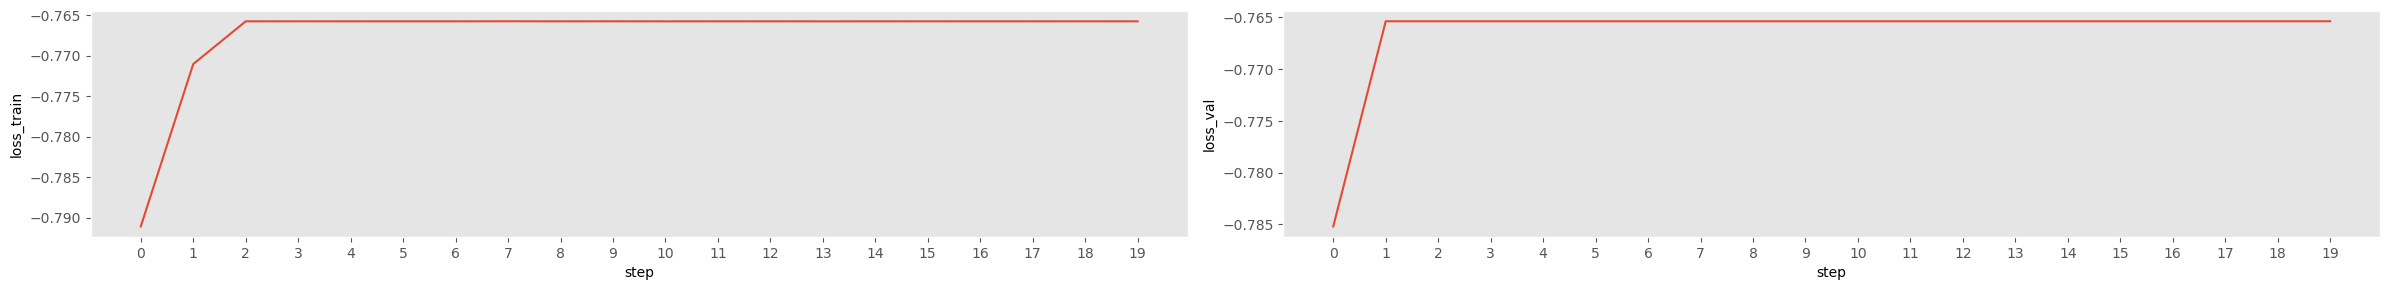

In [ ]:
best_model = train2(model, criterion, optimizer, 20, scheduler)

In [ ]:
model = FeaturePyramidNetwork()


checkpoint = torch.load('best_autoencoder/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.to(device)
model.eval()


FeaturePyramidNetwork(
  (bn0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 24, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
model.eval()
for pic, label in test_loader:
  pic_rec = model(pic.to(device))

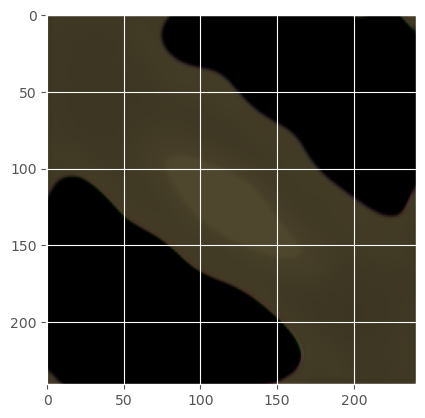

In [ ]:
plt.imshow(torch.permute(pic_rec[2].detach().cpu(), (1,2,0)))